In [2]:
import sys
sys.path.append('../')
import sw_functions as sw
import numpy as np
import jax #https://jax.readthedocs.io/en/latest/notebooks/quickstart.html
import jax.numpy as jnp
import os
from matplotlib import pyplot as plt

In [58]:
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/n/helmod/apps/centos7/Core/cuda/10.1.243-fasrc01/"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

## Pairwise alignment with Smoothed Smith-Waterman

(sim matrix)_{ij} measures the similarity between seq 1 position i and seq 2 position j \
e.g. blosum score between residue at seq 1 position i and residue at seq 2 position j\
e.g. dot product of vector representation of seq 1 position i and seq 2 position j

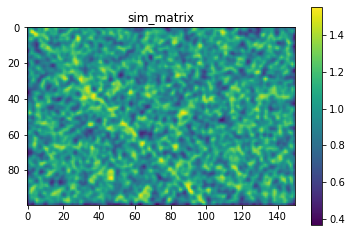

In [3]:
seq_1_len = 100
seq_2_len = 150
sim_matrix = jnp.eye(seq_1_len, seq_2_len) + 2 * jnp.array(np.random.random((seq_1_len, seq_2_len)))
x = jnp.linspace(-3, 3, 7)
import jax.scipy as jsp
window = jsp.stats.norm.pdf(x) * jsp.stats.norm.pdf(x[:, None])
sim_matrix = jsp.signal.convolve(sim_matrix, window, mode='same')
plt.imshow(sim_matrix); plt.colorbar(); plt.title('sim_matrix'); plt.show()

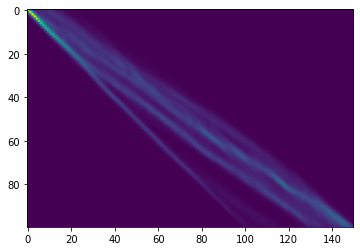

In [4]:
my_sw_func = jax.jit(sw.sw(batch=False))
aln = my_sw_func(sim_matrix, (seq_1_len, seq_2_len), gap=-1)
plt.imshow(aln);

In [5]:
from jax import vjp, custom_vjp, grad
from functools import partial

@partial(jax.custom_vjp)
def blackbox_algorithm(sim_matrix, params):
    return my_sw_func(sim_matrix, (params['seq_1_len'], params['seq_2_len']), gap = params['gap'], temp = params['temp'])

def blackbox_forward(sim_matrix, params):
    return blackbox_algorithm(sim_matrix, params), (sim_matrix, params, blackbox_algorithm(sim_matrix, params))

def blackbox_backward(res, g):
    sim_matrix, params, original_sol = res
    perturbed_sim_matrix = sim_matrix + params['lambda'] * g
    perturbed_sol = blackbox_algorithm(perturbed_sim_matrix, params)
    vjp = (perturbed_sol - original_sol) / params['lambda']
    return (vjp, None)

def loss(gt, pred):
    return jnp.sum(jnp.abs(gt - pred))

blackbox_algorithm.defvjp(blackbox_forward, blackbox_backward)
params = {'seq_1_len': seq_1_len, 'seq_2_len': seq_2_len, 'gap': -1, 'temp': 1, 'lambda': 1.0}
pred = blackbox_algorithm(sim_matrix, params)
ground_truth = jnp.eye(seq_1_len, seq_2_len)
grad_loss = grad(loss)(pred, ground_truth)
alignment, blackbox_algorithm_vjp = jax.vjp(blackbox_algorithm, sim_matrix, params)


Plot predicted alignment and compare with ground-truth

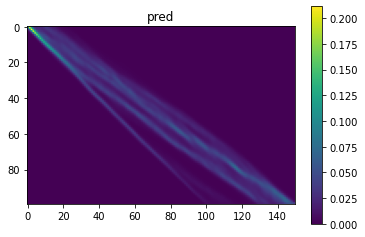

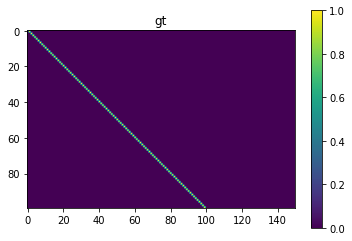

In [6]:
plt.imshow(pred); plt.colorbar(); plt.title('pred'); plt.show()
plt.imshow(ground_truth); plt.colorbar(); plt.title('gt'); plt.show()

Now visualize the gradient of similarity matrix


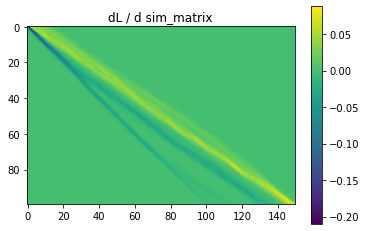

In [7]:
grad_sim_matrix = blackbox_algorithm_vjp(grad_loss)[0]
plt.imshow(grad_sim_matrix); plt.colorbar(); plt.title('dL / d sim_matrix'); plt.show()

If the above gradient is correct then changing similarity matrix in the direction of negative gradient should produce a prediction which is closer to ground-truth than before.

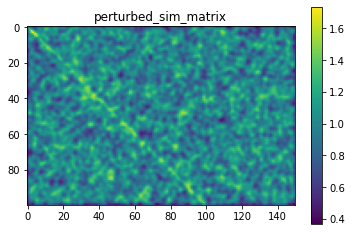

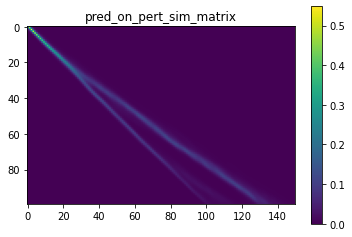

Original loss: 176.131
Loss after changing similarity matrix (should be less than original loss): 156.376


In [9]:
perturbed_sim_matrix = sim_matrix - grad_sim_matrix # Better similarity matrix taking into account the gradient.
plt.imshow(perturbed_sim_matrix); plt.colorbar(); plt.title('perturbed_sim_matrix'); plt.show()
pred_on_pert_sim_matrix = blackbox_algorithm(perturbed_sim_matrix, params)
plt.imshow(pred_on_pert_sim_matrix); plt.colorbar(); plt.title('pred_on_pert_sim_matrix'); plt.show()
print(f"Original loss: {loss(pred, ground_truth):.3f}")
print(f"Loss after changing similarity matrix (should be less than original loss): {loss(pred_on_pert_sim_matrix, ground_truth):.3f}")